In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import computekernel
from reckernel import RecKernel
from kuramoto import KS
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Kuramoto data generation and kernel test

In [2]:
L    = 6
N    = 100
dt   = 0.25
ninittransients = 1000
tend = 5000 + ninittransients*dt  #50000
dns  = KS(L=L, N=N, dt=dt, tend=tend)

N_data_train = 10000
N_data_test = 10000

dns.simulate()
u = dns.uu[ninittransients:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_data_train, N_data_train+N_data_test], axis=0)

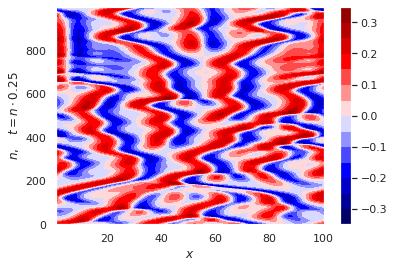

In [3]:
N_plot = 1000
u_plot = u[:N_plot,:]
N_plot = np.shape(u_plot)[0]
# Plotting the contour plot
fig = plt.subplots()
# t, s = np.meshgrid(np.arange(N_plot)*dt, np.array(range(N))+1)
n, s = np.meshgrid(np.arange(N_plot), np.array(range(N))+1)
plt.contourf(s, n, np.transpose(u_plot), 15, cmap=plt.get_cmap("seismic"))
plt.colorbar()
plt.xlabel(r"$x$")
plt.ylabel(r"$n, \quad t=n \cdot {:}$".format(dt));

#     plt.savefig(base_path + "/Figures/Plot_U_first_N{:d}.png".format(N_plot), bbox_inches="tight")
#     plt.close()

In [4]:
def gaussian_data(n_input, input_len_max, input_dim, fix_seed=False):
    if fix_seed == True:
        torch.manual_seed(42)
    return torch.randn(n_input, input_len_max, input_dim).to(device) / np.sqrt(input_dim)

# Arcsin kernel and RC

In [5]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)
# n_res_range = np.arange(start=100,stop=8000, step=1000)
n_res_range = np.logspace(2, 4.5, num=25, dtype=int)
error_rc_asin = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', random_projection='gaussian')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_rc_asin[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

25it [15:52, 38.11s/it] 


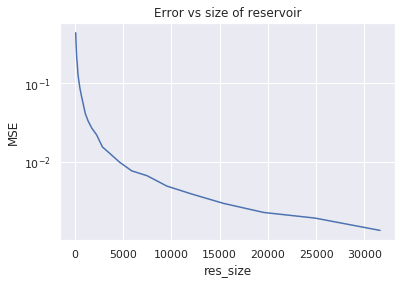

In [6]:
plt.semilogy(n_res_range, error_rc_asin.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

In [7]:
np.save('out/200519_conv_rc_asin_len40_1e2to1e45', error_rc_asin)

# Arcsin and SRC

In [8]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_asin = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', random_projection='structured')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_asin[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:24,  1.65s/it]


Text(0, 0.5, 'MSE')

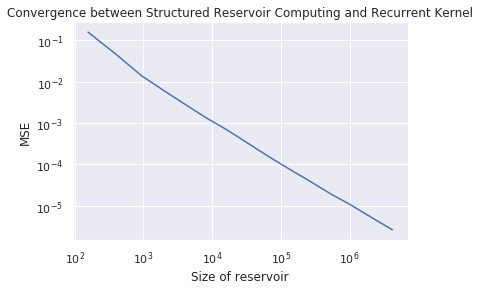

In [9]:
plt.loglog(n_res_range, error_src_asin.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [10]:
np.save('out/200519_conv_src_asin_len40_2p8to2p22', error_src_asin)

# RBF kernel and RC

In [11]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=100,stop=8000, step=1000)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_rbf = torch.zeros(len(n_res_range))

with torch.no_grad():
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    #     K = computekernel.arcsin(input_data, initial_state, scale_res)
        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        for n_in in range(n_input):
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='cos_rbf', random_projection='gaussian')
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]
            del X

        del model
        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_rbf[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

18it [00:57,  3.19s/it]


RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 10.76 GiB total capacity; 8.57 GiB already allocated; 104.19 MiB free; 9.80 GiB reserved in total by PyTorch)

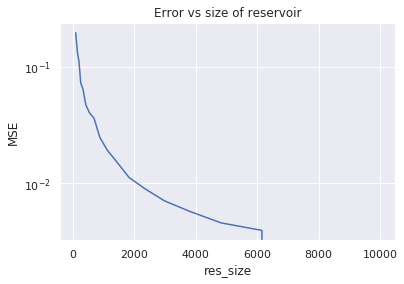

In [12]:
plt.semilogy(n_res_range, error_rc_rbf.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

In [13]:
np.save('out/200519_conv_rc_rbf_len40_1e2to1e4', error_rc_rbf)

# RBF kernel and SRC

In [14]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_rbf = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    
#     torch.manual_seed(1)
#     bias = 2 * np.pi * torch.rand(n_res).to(device)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='cos_rbf', random_projection='structured')
    for n_in in range(n_input):
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_rbf[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:15,  1.04s/it]


Text(0, 0.5, 'MSE')

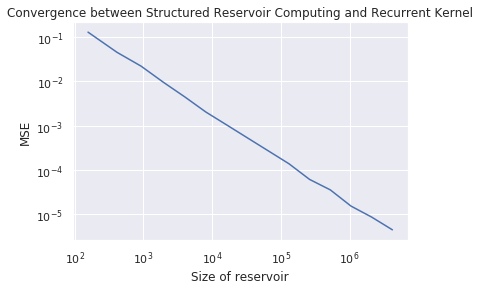

In [15]:
plt.loglog(n_res_range, error_src_rbf.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [16]:
np.save('out/200519_conv_src_rbf_len40_1e2to1e4', error_src_rbf)

# Acos and RC

In [19]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='acos heaviside', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=100,stop=8000, step=1000)
n_res_range = np.logspace(2, 4.5, num=25, dtype=int)
error_rc_acos = torch.zeros(len(n_res_range))

with torch.no_grad():
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    #     K = computekernel.arcsin(input_data, initial_state, scale_res)
        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        for n_in in range(n_input):
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                                  f='heaviside', random_projection='gaussian')
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]
            del X

        del model
        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_acos[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

23it [06:13, 16.23s/it]


RuntimeError: CUDA out of memory. Tried to allocate 2.31 GiB (GPU 0; 10.76 GiB total capacity; 2.68 GiB already allocated; 110.19 MiB free; 9.80 GiB reserved in total by PyTorch)

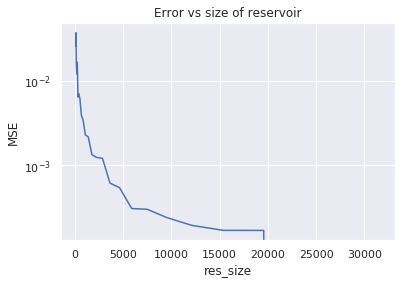

In [20]:
plt.semilogy(n_res_range, error_rc_acos.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

In [21]:
np.save('out/200519_conv_rc_acos_len40_1e2to1e45', error_rc_acos)

# RBF kernel and SRC

In [22]:
#arcsin kernel
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='acos heaviside', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_acos = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    
#     torch.manual_seed(1)
#     bias = 2 * np.pi * torch.rand(n_res).to(device)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='heaviside', random_projection='structured')
    for n_in in range(n_input):
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_acos[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:15,  1.01s/it]


Text(0, 0.5, 'MSE')

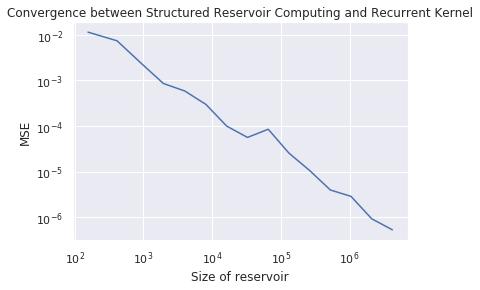

In [23]:
plt.loglog(n_res_range, error_src_acos.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [21]:
np.save('out/200519_conv_src_acos_len40_1e2to1e4', error_src_acos)

# Sign/Asin and RC

In [24]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='asin sign', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=100,stop=8000, step=1000)
n_res_range = np.logspace(2, 4.5, num=25, dtype=int)
error_rc_asin2 = torch.zeros(len(n_res_range))

with torch.no_grad():
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    #     K = computekernel.arcsin(input_data, initial_state, scale_res)
        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        for n_in in range(n_input):
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                                  f='sign', random_projection='gaussian')
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]
            del X

        del model
        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin2[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

23it [06:10, 16.13s/it]


RuntimeError: CUDA out of memory. Tried to allocate 2.31 GiB (GPU 0; 10.76 GiB total capacity; 2.68 GiB already allocated; 110.19 MiB free; 9.80 GiB reserved in total by PyTorch)

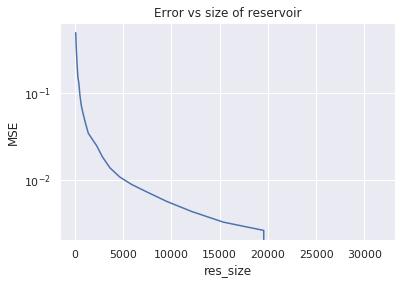

In [25]:
plt.semilogy(n_res_range, error_rc_asin2.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

In [26]:
np.save('out/200519_conv_rc_asin2_len40_1e2to1e45', error_rc_asin2)

# RBF kernel and SRC

In [27]:
#arcsin kernel
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='asin sign', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_asin2 = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    
#     torch.manual_seed(1)
#     bias = 2 * np.pi * torch.rand(n_res).to(device)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='sign', random_projection='structured')
    for n_in in range(n_input):
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_asin2[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:14,  1.06it/s]


Text(0, 0.5, 'MSE')

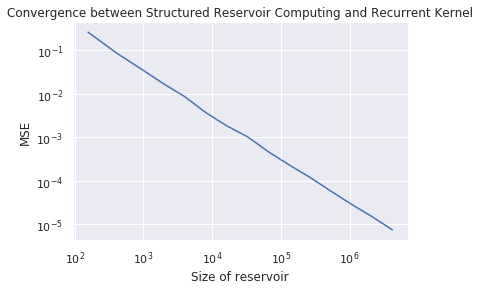

In [28]:
plt.loglog(n_res_range, error_src_asin2.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [29]:
np.save('out/200519_conv_src_asin2_len40_1e2to1e4', error_src_asin2)

# Prediction on Kuramoto


In [3]:
u_train_t = torch.from_numpy(u_train).to(device)
pred_horizon = 5

n_input = 1 # number of time series
input_len, input_dim = u_train_t.shape # time steps t
# input_dim = 32 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

n_res = 1000
initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=1)
X = model.forward(u_train_t, initial_state=initial_state).to(device)
print(X.shape)

torch.Size([10000, 1000])


In [4]:
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
print(out_train.shape)

torch.Size([10000, 100])


In [5]:
output_w = model.train(X, out_train)
print(output_w.shape)

pred_output = X @ output_w

torch.Size([1000, 100])


In [6]:
u_test_t = torch.from_numpy(u_test).to(device)
out_test = torch.roll(u_test_t, -pred_horizon, dims=0)

Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
pred_output_test = Xtest @ output_w

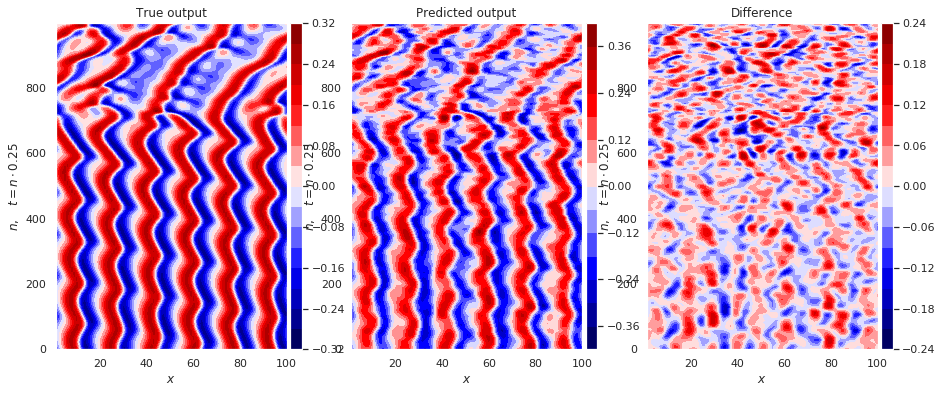

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_orig = 2000
N_plot = 1000
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

u_plot = out_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
n, s = np.meshgrid(np.array(range(N))+1, np.arange(N_plot))
plot = axes[0].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = pred_output_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[1].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = (pred_output_test-out_test).cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[2].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

# Prediction on Kuramoto (with more data for training)

In [8]:
u_train_t = torch.from_numpy(u_train).to(device)
pred_horizon = 5

n_input = 1 # number of time series
input_len, input_dim = u_train_t.shape # time steps t
# input_dim = 32 #dimension of the time series
input_scale = 0.1  # variance of input
res_scale = 1 # variance of reservoir

n_res = 1000
initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=1)
X = model.forward(u_train_t, initial_state=initial_state).to(device)
print(X.shape)

torch.Size([10000, 1000])


In [9]:
X2 = torch.cat((X, u_train_t), 1)
print(X2.shape)

torch.Size([10000, 1100])


In [10]:
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
print(out_train.shape)

torch.Size([10000, 100])


In [11]:
output_w = model.train(X2, out_train)
print(output_w.shape)

pred_output = X2 @ output_w

RuntimeError: cholesky_cuda: U(1024,1024) is zero, singular U.

In [12]:
u_test_t = torch.from_numpy(u_test).to(device)
out_test = torch.roll(u_test_t, -pred_horizon, dims=0)

Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
Xtest2 = torch.cat((Xtest, u_test_t), 1)
pred_output_test = Xtest2 @ output_w

RuntimeError: size mismatch, m1: [10000 x 1100], m2: [1000 x 100] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_orig = 2000
N_plot = 1000
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

u_plot = out_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
n, s = np.meshgrid(np.array(range(N))+1, np.arange(N_plot))
plot = axes[0].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = pred_output_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[1].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = (pred_output_test-out_test).cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[2].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

It works okay, and gets better with 5'000 neurons.

# Stability test

In [26]:
input_data = torch.from_numpy(u_train).to(device)
input_len = 100
input_data = input_data[:input_len, :]
# input_data /= np.sqrt(input_data.shape[1])

n_input = 1 # number of time series
input_len, input_dim = input_data.shape # time steps t
# input_dim = 32 #dimension of the time series
input_scale = .2  # variance of input
res_scale = 1 # variance of reservoir

n_res = 1000
torch.manual_seed(1)
initial_state1 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=1)
X1 = model.forward(input_data, initial_state=initial_state1).to(device)

torch.manual_seed(2)
initial_state2 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=1)
X2 = model.forward(input_data, initial_state=initial_state2).to(device)

torch.Size([100, 1000])


Text(0.5, 0, 'Time')

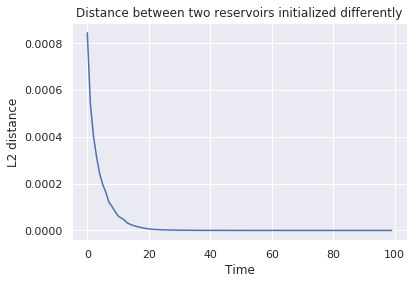

In [28]:
diff = X2 - X1
print(diff.shape)
plt.plot(torch.mean(torch.abs(diff)**2, axis=1).cpu())
plt.title('Distance between two reservoirs initialized differently')
plt.ylabel('L2 distance')
plt.xlabel('Time')

We will thus take 100 steps to initialize our recursive kernels (so that they don't depend on the initial state).

# Recurrent kernel computation

In [50]:
train_gram_size = 10000
input_data = torch.from_numpy(u_train).to(device)
input_data = input_data[:train_gram_size, :]

length_of_interest = 40
input_len, input_dim = input_data.shape # time steps t
n_input = input_len - length_of_interest
input_len = length_of_interest

gram_input = torch.zeros(n_input, input_len, input_dim).to(device)
for i_in in range(n_input):
    gram_input[i_in, :, :] = input_data[i_in:i_in+input_len, :]
print(gram_input.shape)
print(gram_input[:2, :5, 0])

torch.Size([9960, 40, 100])
tensor([[-0.0352, -0.0421, -0.0480, -0.0523, -0.0548],
        [-0.0421, -0.0480, -0.0523, -0.0548, -0.0553]], device='cuda:0')


In [51]:
RK = RecKernel(function='arcsin', memory_efficient=False)
K = RK.forward(gram_input)
print(K.shape)

torch.Size([9960, 9960])


In [24]:
RK = RecKernel(function='arcsin', memory_efficient=True, n_iter=40)
K = RK.forward(input_data)
print(K.shape)

torch.Size([9960, 9960])


In [52]:
pred_horizon = 5

out_train = torch.roll(input_data, -pred_horizon, dims=0)
out_train = out_train[length_of_interest:, :]
print(out_train.shape)

torch.Size([9960, 100])


In [53]:
from sklearn.linear_model import Ridge
clf = Ridge(fit_intercept=False, alpha=1e-1)
clf.fit(K.cpu().numpy(), out_train.cpu().numpy())
output_w = torch.from_numpy(clf.coef_.T).to(device)
print(output_w.shape)

pred_output = K @ output_w

torch.Size([9960, 100])


In [66]:
test_gram_size = 3000
input_data = torch.from_numpy(u_test).to(device)
input_data = input_data[:test_gram_size, :]
n_input = test_gram_size - length_of_interest
pred_horizon = 5

out_test = torch.roll(input_data, -pred_horizon, dims=0)
out_test = out_test[length_of_interest:, :]

gram_input_test = torch.zeros(n_input, input_len, input_dim).to(device)
for i_in in range(n_input):
    gram_input_test[i_in, :, :] = input_data[i_in:i_in+input_len, :]

RK = RecKernel(function='arcsin', memory_efficient=False)
K_test = RK.forward_test(gram_input, gram_input_test)
print(K_test.shape)

pred_output_test = K_test @ output_w
print(pred_output_test.shape)

torch.Size([2960, 9960])
torch.Size([2960, 100])


In [75]:
test_gram_size = 3000
input_data = torch.from_numpy(u_test).to(device)
input_data = input_data[:test_gram_size, :]
n_input = test_gram_size - length_of_interest

out_test = torch.roll(input_data, -pred_horizon, dims=0)
out_test = out_test[length_of_interest:, :]

gram_input_test = torch.zeros(n_input, input_len, input_dim).to(device)
for i_in in range(n_input):
    gram_input_test[i_in, :, :] = input_data[i_in:i_in+input_len, :]

final_input_test = torch.cat((gram_input, gram_input_test), dim=0)

K_test = computekernel.arcsin(final_input_test, initial_state, scale_res=1, scale_in=0.1)
print(K_test.shape)

pred_output_test = K_test[-test_gram_size+length_of_interest:, :train_gram_size-length_of_interest] @ output_w
print(pred_output_test.shape)

torch.Size([12920, 12920])
torch.Size([2960, 100])


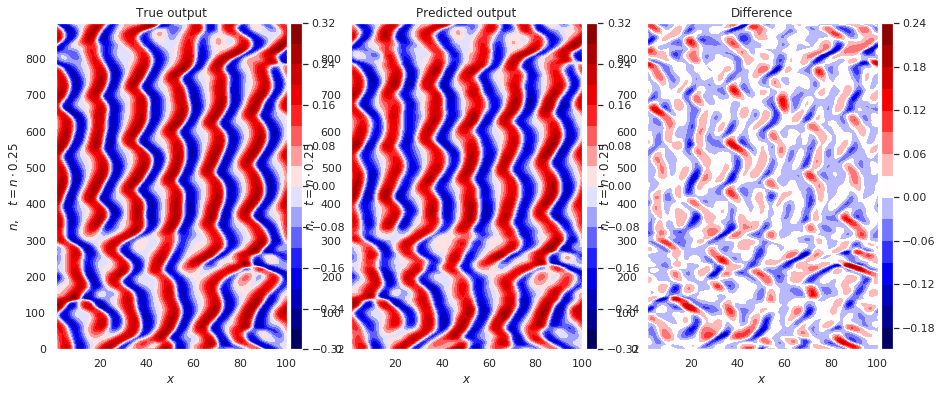

In [67]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_orig = 2000
N_plot = 900
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

u_plot = out_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
n, s = np.meshgrid(np.array(range(N))+1, np.arange(N_plot))
plot = axes[0].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = pred_output_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[1].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = (pred_output_test-out_test).cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[2].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

In [64]:
from reckernel import RecKernel
RK = RecKernel(function='arcsin', memory_efficient=True, n_iter=100, input_scale=0.1)
stability_curve = RK.stability_test(input_data)
print(stability_curve.shape)

torch.Size([100])


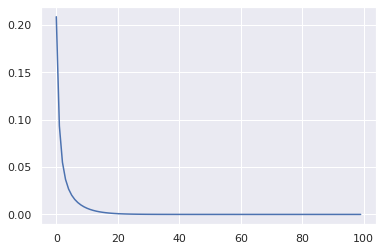

In [65]:
plt.plot(stability_curve.cpu())